## TME IAR - Deep Learning for Image Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
# from torch.autograd import Variable
# from PIL import ImageFile
from dataloader import *
from plotdata import *
# import os
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.01
momentum = 0.5
batch_size_train = 40
batch_size_test = 500

In [3]:
# evaluation on a batch of test data:
def evaluate(model, data):
    batch_enum = enumerate(data.loader_test)
    batch_idx, (testdata, testtargets) = next(batch_enum)
    testdata = testdata.to(device)
    testtargets = testtargets.to(device)
    model = model.eval()
    oupt = torch.argmax(model(testdata), dim=1)
    t = torch.sum(oupt == testtargets)
    result = t * 100.0 / len(testtargets)
    model = model.train()
    print(f"{t} correct on {len(testtargets)} ({result.item()} %)")
    return result.item()


# iteratively train on batches for one epoch:
def train_epoch(model, optimizer, data, loss_record):
    batch_enum = enumerate(data.loader_train)
    i_count = 0
    iterations = data.num_train_samples // data.batch_size_train
    for batch_idx, (dt, targets) in batch_enum:
        i_count = i_count+1
        dt = dt.to(device)
        outputs = model(dt)
        targets = targets.to(device)
        loss = F.cross_entropy(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if not i_count % 30:
            print(f"    step {i_count} / {iterations}")
            loss_record.append(loss.item())
        if i_count == iterations:
            break


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.dropout3 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(((((75-2)//2-2)//2)**2)*64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)
        
        # print('size:', ((((75-2)//2-2)//2)**2)*64) # 18496

    def forward(self, x):
        x = F.relu(self.conv1(x.view(-1, 3, 75, 75)))
        x = self.dropout1(F.max_pool2d(x, 2))
        x = F.relu(self.conv2(x))
        x = self.dropout2(F.max_pool2d(x, 2))
        x = torch.flatten(x, 1)
        x = self.dropout3(F.relu(self.fc1(x)))
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [4]:
data = loadImgs(batch_size_train=batch_size_train, batch_size_test=batch_size_test)

net = Net().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

net.load_state_dict(torch.load('./data/model_TP.pt'))

<All keys matched successfully>

In [8]:
batch_enum = enumerate(data.loader_test)
batch_idx, (testdata, testtargets) = next(batch_enum)
testdata = testdata.to(device)
testtargets = testtargets.to(device)
net = net.eval()
out = net(testdata)
pred = torch.argmax(net(testdata), dim=1)
net.train()

In [10]:
out

tensor([[ 9.0384e-01, -8.1435e-01],
        [-5.0312e-01,  5.6899e-01],
        [-1.6244e+00,  1.7174e+00],
        [-2.6535e-01,  3.6269e-01],
        [-1.0691e-01,  2.0909e-01],
        [-4.3296e-01,  5.2933e-01],
        [ 3.5563e-01, -2.9214e-01],
        [ 5.3484e-01, -4.9618e-01],
        [-2.2015e+00,  2.3145e+00],
        [-1.8703e+00,  1.9901e+00],
        [ 1.3177e-01, -6.7716e-02],
        [ 3.6076e-01, -2.5702e-01],
        [-5.3242e-01,  6.2900e-01],
        [ 1.7723e+00, -1.8009e+00],
        [-3.3897e-01,  4.1783e-01],
        [-5.0345e-01,  6.0017e-01],
        [ 1.3151e+00, -1.2829e+00],
        [ 6.7094e-01, -6.0397e-01],
        [ 3.8144e-01, -3.5498e-01],
        [ 1.1189e+00, -1.0460e+00],
        [-1.0874e+00,  1.2284e+00],
        [ 1.0627e+00, -1.0026e+00],
        [ 8.1746e-01, -7.7134e-01],
        [ 1.6215e+00, -1.6268e+00],
        [ 7.4206e-01, -6.7702e-01],
        [-1.0239e+00,  1.1210e+00],
        [ 4.4421e-01, -3.7282e-01],
        [-6.2903e-02,  1.233

In [24]:
pred.shape

torch.Size([500])

In [13]:
testtargets

tensor([0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,

In [14]:
from sklearn.metrics import confusion_matrix

In [16]:
confusion_matrix(testtargets.cpu(), pred.cpu())

array([[199,  55],
       [ 20, 226]])

In [17]:
import pandas as pd
y_actu = pd.Series(testtargets.cpu(), name='Actual')
y_pred = pd.Series(pred.cpu(), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)

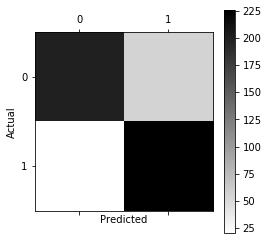

In [20]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_confusion)

In [21]:
import seaborn as sn

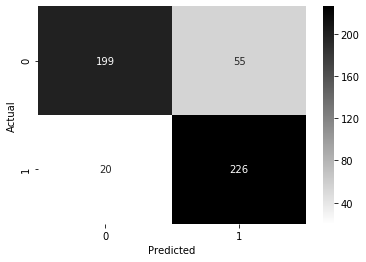

In [28]:
heatmap = sn.heatmap(df_confusion, annot=True, fmt=".0f", cmap=plt.cm.gray_r)

In [30]:
heatmap.get_figure().savefig("confusion" + ".svg", format="svg")

In [9]:
def eval_net(its = 1):
    acc = 0

    print('Doing', its, 'evaluations:')
    for i in range(its):
        eval = evaluate(net, data)
        print(i+1, ') ', eval)
        acc = acc + eval

    med = acc/its
    print('Final medium evaluation:', med)

eval_net(20)

Doing 20 evaluations:
411 correct on 500 (82.20000457763672 %)
1 )  82.20000457763672
387 correct on 500 (77.4000015258789 %)
2 )  77.4000015258789
408 correct on 500 (81.60000610351562 %)
3 )  81.60000610351562
415 correct on 500 (83.00000762939453 %)
4 )  83.00000762939453
414 correct on 500 (82.80000305175781 %)
5 )  82.80000305175781
417 correct on 500 (83.4000015258789 %)
6 )  83.4000015258789
420 correct on 500 (84.00000762939453 %)
7 )  84.00000762939453
418 correct on 500 (83.60000610351562 %)
8 )  83.60000610351562
405 correct on 500 (81.00000762939453 %)
9 )  81.00000762939453
424 correct on 500 (84.80000305175781 %)
10 )  84.80000305175781
419 correct on 500 (83.80000305175781 %)
11 )  83.80000305175781
425 correct on 500 (85.00000762939453 %)
12 )  85.00000762939453
411 correct on 500 (82.20000457763672 %)
13 )  82.20000457763672
419 correct on 500 (83.80000305175781 %)
14 )  83.80000305175781
421 correct on 500 (84.20000457763672 %)
15 )  84.20000457763672
421 correct on 5

In [6]:
def train_net(loss_record, num_epochs = 1): 
    for j in range(num_epochs):
        print(f"epoch {j} / {num_epochs}")
        train_epoch(net, optimizer, data, loss_record)
        evaluate(net, data)
        torch.save(net.state_dict(), './data/model_TP.pt')

    indices = np.random.choice(range(data.num_test_samples), 20)

#     plotdata(data, indices, net, original=True)

In [7]:
# doing 5th epoch now
loss_record = []
train_net(loss_record, num_epochs=35)

epoch 0 / 35
    step 30 / 1000
    step 60 / 1000
    step 90 / 1000
    step 120 / 1000
    step 150 / 1000
    step 180 / 1000
    step 210 / 1000
    step 240 / 1000
    step 270 / 1000
    step 300 / 1000
    step 330 / 1000
    step 360 / 1000
    step 390 / 1000
    step 420 / 1000
    step 450 / 1000
    step 480 / 1000
    step 510 / 1000
    step 540 / 1000
    step 570 / 1000
    step 600 / 1000
    step 630 / 1000
    step 660 / 1000
    step 690 / 1000
    step 720 / 1000
    step 750 / 1000
    step 780 / 1000
    step 810 / 1000
    step 840 / 1000
    step 870 / 1000
    step 900 / 1000
    step 930 / 1000
    step 960 / 1000
    step 990 / 1000
301 correct on 500 (60.20000457763672 %)
epoch 1 / 35
    step 30 / 1000
    step 60 / 1000
    step 90 / 1000
    step 120 / 1000
    step 150 / 1000
    step 180 / 1000
    step 210 / 1000
    step 240 / 1000
    step 270 / 1000
    step 300 / 1000
    step 330 / 1000
    step 360 / 1000
    step 390 / 1000
    step 420 / 1000

    step 600 / 1000
    step 630 / 1000
    step 660 / 1000
    step 690 / 1000
    step 720 / 1000
    step 750 / 1000
    step 780 / 1000
    step 810 / 1000
    step 840 / 1000
    step 870 / 1000
    step 900 / 1000
    step 930 / 1000
    step 960 / 1000
    step 990 / 1000
384 correct on 500 (76.80000305175781 %)
epoch 12 / 35
    step 30 / 1000
    step 60 / 1000
    step 90 / 1000
    step 120 / 1000
    step 150 / 1000
    step 180 / 1000
    step 210 / 1000
    step 240 / 1000
    step 270 / 1000
    step 300 / 1000
    step 330 / 1000
    step 360 / 1000
    step 390 / 1000
    step 420 / 1000
    step 450 / 1000
    step 480 / 1000
    step 510 / 1000
    step 540 / 1000
    step 570 / 1000
    step 600 / 1000
    step 630 / 1000
    step 660 / 1000
    step 690 / 1000
    step 720 / 1000
    step 750 / 1000
    step 780 / 1000
    step 810 / 1000
    step 840 / 1000
    step 870 / 1000
    step 900 / 1000
    step 930 / 1000
    step 960 / 1000
    step 990 / 1000
389 corr

    step 120 / 1000
    step 150 / 1000
    step 180 / 1000
    step 210 / 1000
    step 240 / 1000
    step 270 / 1000
    step 300 / 1000
    step 330 / 1000
    step 360 / 1000
    step 390 / 1000
    step 420 / 1000
    step 450 / 1000
    step 480 / 1000
    step 510 / 1000
    step 540 / 1000
    step 570 / 1000
    step 600 / 1000
    step 630 / 1000
    step 660 / 1000
    step 690 / 1000
    step 720 / 1000
    step 750 / 1000
    step 780 / 1000
    step 810 / 1000
    step 840 / 1000
    step 870 / 1000
    step 900 / 1000
    step 930 / 1000
    step 960 / 1000
    step 990 / 1000
407 correct on 500 (81.4000015258789 %)
epoch 24 / 35
    step 30 / 1000
    step 60 / 1000
    step 90 / 1000
    step 120 / 1000
    step 150 / 1000
    step 180 / 1000
    step 210 / 1000
    step 240 / 1000
    step 270 / 1000
    step 300 / 1000
    step 330 / 1000
    step 360 / 1000
    step 390 / 1000
    step 420 / 1000
    step 450 / 1000
    step 480 / 1000
    step 510 / 1000
    step 

    step 690 / 1000
    step 720 / 1000
    step 750 / 1000
    step 780 / 1000
    step 810 / 1000
    step 840 / 1000
    step 870 / 1000
    step 900 / 1000
    step 930 / 1000
    step 960 / 1000
    step 990 / 1000
414 correct on 500 (82.80000305175781 %)


In [8]:
def print_loss(loss_record):
    N = len(loss_record)
    plt.plot(range(N), loss_record, 'ro')
    plt.axis([0, N-1, 0, 1])
    plt.show()

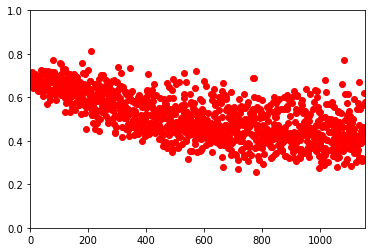

In [9]:
print_loss(loss_record) # 35 epoch

In [13]:
import pickle
pickle.dump(loss_record, open('loss_record.txt', 'wb'))

In [69]:
eval_net() # 5th epoch

Doing 1 evaluations:
320 correct on 500 (64.0 %)
1 )  64.0
Final medium evaluation: 64.0


epoch 0 / 1
    step 30 / 1000
    step 60 / 1000
    step 90 / 1000
    step 120 / 1000
    step 150 / 1000
    step 180 / 1000
    step 210 / 1000
    step 240 / 1000
    step 270 / 1000
    step 300 / 1000
    step 330 / 1000
    step 360 / 1000
    step 390 / 1000
    step 420 / 1000
    step 450 / 1000
    step 480 / 1000
    step 510 / 1000
    step 540 / 1000
    step 570 / 1000
    step 600 / 1000
    step 630 / 1000
    step 660 / 1000
    step 690 / 1000
    step 720 / 1000
    step 750 / 1000
    step 780 / 1000
    step 810 / 1000
    step 840 / 1000
    step 870 / 1000
    step 900 / 1000
    step 930 / 1000
    step 960 / 1000
    step 990 / 1000
326 correct on 500 (65.19999694824219 %)


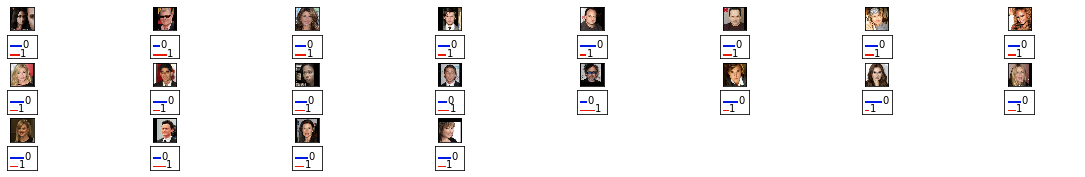

In [70]:
# 6th epoch
train_net(loss_record)

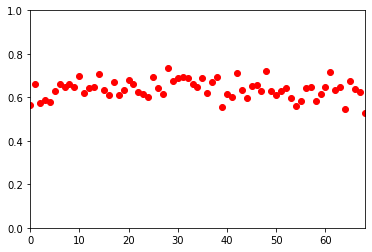

Doing 1 evaluations:
326 correct on 500 (65.19999694824219 %)
1 )  65.19999694824219
Final medium evaluation: 65.19999694824219


In [72]:
print_loss(loss_record) # 5th and 6th epochs
eval_net() # 6th epoch

In [73]:
eval_net(20) # 6th epoch

Doing 20 evaluations:
334 correct on 500 (66.80000305175781 %)
1 )  66.80000305175781
327 correct on 500 (65.4000015258789 %)
2 )  65.4000015258789
321 correct on 500 (64.19999694824219 %)
3 )  64.19999694824219
337 correct on 500 (67.4000015258789 %)
4 )  67.4000015258789
326 correct on 500 (65.19999694824219 %)
5 )  65.19999694824219
334 correct on 500 (66.80000305175781 %)
6 )  66.80000305175781
332 correct on 500 (66.4000015258789 %)
7 )  66.4000015258789
342 correct on 500 (68.4000015258789 %)
8 )  68.4000015258789
332 correct on 500 (66.4000015258789 %)
9 )  66.4000015258789
338 correct on 500 (67.5999984741211 %)
10 )  67.5999984741211
323 correct on 500 (64.5999984741211 %)
11 )  64.5999984741211
314 correct on 500 (62.79999923706055 %)
12 )  62.79999923706055
340 correct on 500 (68.0 %)
13 )  68.0
317 correct on 500 (63.400001525878906 %)
14 )  63.400001525878906
322 correct on 500 (64.4000015258789 %)
15 )  64.4000015258789
325 correct on 500 (65.0 %)
16 )  65.0
328 correct o

In [74]:
loss_record5_6_epochs = loss_record

epoch 0 / 1
    step 30 / 1000
    step 60 / 1000
    step 90 / 1000
    step 120 / 1000
    step 150 / 1000
    step 180 / 1000
    step 210 / 1000
    step 240 / 1000
    step 270 / 1000
    step 300 / 1000
    step 330 / 1000
    step 360 / 1000
    step 390 / 1000
    step 420 / 1000
    step 450 / 1000
    step 480 / 1000
    step 510 / 1000
    step 540 / 1000
    step 570 / 1000
    step 600 / 1000
    step 630 / 1000
    step 660 / 1000
    step 690 / 1000
    step 720 / 1000
    step 750 / 1000
    step 780 / 1000
    step 810 / 1000
    step 840 / 1000
    step 870 / 1000
    step 900 / 1000
    step 930 / 1000
    step 960 / 1000
    step 990 / 1000
290 correct on 500 (58.0 %)


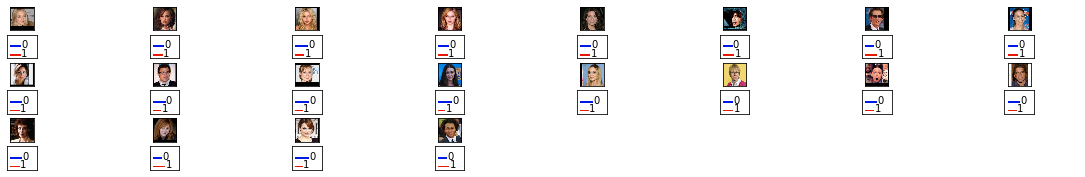

In [82]:
# back to 1st epoch now
loss_record = []
train_net(loss_record)

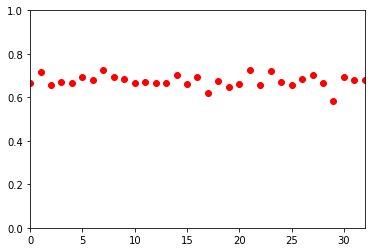

Doing 1 evaluations:
305 correct on 500 (61.0 %)
1 )  61.0
Final medium evaluation: 61.0


In [83]:
print_loss(loss_record) # after 1st epoch
eval_net() 

In [88]:
intermed = [0]*99

list